In [2]:
!pip install faker


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 14.8 MB/s eta 0:00:00


In [3]:
import csv
import random
from faker import Faker

fake = Faker()
num_records = 10000
csv_file = "student_records.csv"

def generate_marks():
    return random.randint(0, 100)

with open(csv_file, mode="w", newline="") as file:
    writer = csv.writer(file)

    writer.writerow([
        "student_id",
        "name",
        "electronics_marks",
        "programming_marks",
        "database_marks",
        "datascience_marks",
        "mathematics_marks",
        "dsa_marks"
    ])

    for student_id in range(1, num_records + 1):
        writer.writerow([
            student_id,
            fake.name(),
            generate_marks(),
            generate_marks(),
            generate_marks(),
            generate_marks(),
            generate_marks(),
            generate_marks()
        ])

print(f"{num_records} student records have been generated succesfully and they have been saved to '{csv_file}' ")


10000 student records have been generated succesfully and they have been saved to 'student_records.csv' 


In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col

spark = SparkSession.builder \
    .appName("StudentRecordsProcessing") \
    .getOrCreate()

df = spark.read.csv("student_records.csv", header=True, inferSchema=True)
df.show(5)
df_with_avg = df.withColumn(
    "average_marks",
    (
        col("electronics_marks") +
        col("programming_marks") +
        col("database_marks") +
        col("datascience_marks") +
        col("mathematics_marks") +
        col("dsa_marks")
    ) / 6
)

df_with_avg.show(5)
high_achievers = df_with_avg.filter(col("average_marks") > 75)
print("Students with average marks above 75:")
high_achievers.show(5)
high_achievers.write.csv("high_achievers.csv", header=True, mode="overwrite")
print("Processed data has been saved to 'high_achievers.csv'.")

spark.stop()

+----------+---------------+-----------------+-----------------+--------------+-----------------+-----------------+---------+
|student_id|           name|electronics_marks|programming_marks|database_marks|datascience_marks|mathematics_marks|dsa_marks|
+----------+---------------+-----------------+-----------------+--------------+-----------------+-----------------+---------+
|         1|      Jack Pope|               53|               91|            27|               41|              100|       82|
|         2| Robert Coleman|               53|               81|            54|               39|               24|       39|
|         3|   John Manning|               16|               67|            67|                3|               95|       20|
|         4|  Sarah Patrick|                3|                3|            55|               50|               59|       66|
|         5|Beverly Miranda|               58|               90|            71|               63|               10|   

+----------+---------------+-----------------+-----------------+--------------+-----------------+-----------------+---------+
|student_id|           name|electronics_marks|programming_marks|database_marks|datascience_marks|mathematics_marks|dsa_marks|
+----------+---------------+-----------------+-----------------+--------------+-----------------+-----------------+---------+
|         1|      Jack Pope|               53|               91|            27|               41|              100|       82|
|         2| Robert Coleman|               53|               81|            54|               39|               24|       39|
|         3|   John Manning|               16|               67|            67|                3|               95|       20|
|         4|  Sarah Patrick|                3|                3|            55|               50|               59|       66|
|         5|Beverly Miranda|               58|               90|            71|               63|               10|   

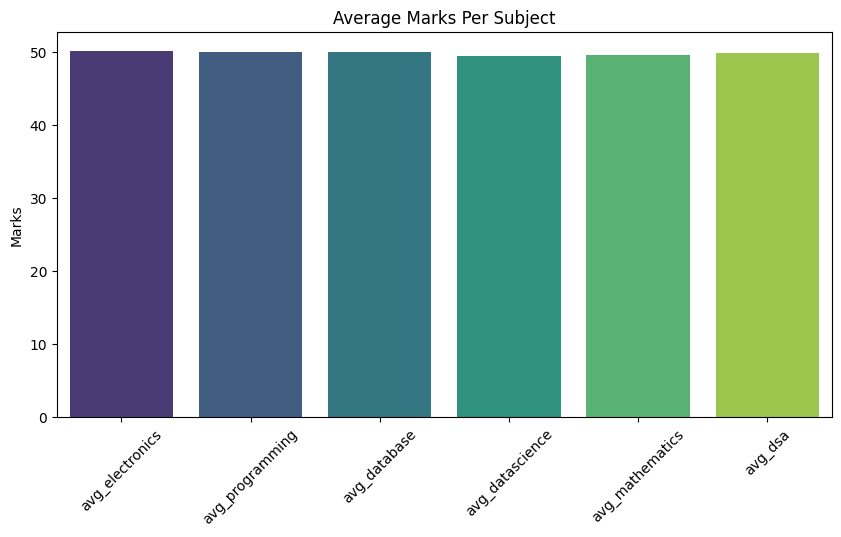

+--------------------+-----+
|performance_category|count|
+--------------------+-----+
|  Average Performers| 4851|
|      Low Performers| 4986|
|      High Achievers|  163|
+--------------------+-----+



<ipython-input-9-3af0ba59996a>:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="performance_category", y="count", data=category_counts_pd, palette="coolwarm")


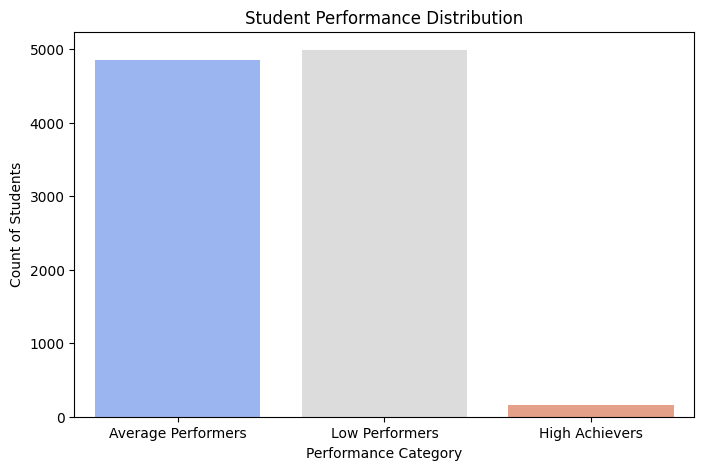

Processed data is saved to 'student_performance.csv'.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, round as spark_round
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


spark = SparkSession.builder \
    .appName("StudentRecordsProcessing") \
    .getOrCreate()

df = spark.read.csv("student_records.csv", header=True, inferSchema=True)

df.show(5)

df_with_avg = df.withColumn(
    "average_marks",
    spark_round(
        (
            col("electronics_marks") +
            col("programming_marks") +
            col("database_marks") +
            col("datascience_marks") +
            col("mathematics_marks") +
            col("dsa_marks")
        ) / 6, 2
    )
)

df_with_avg.show(5)
subject_avg = df_with_avg.select(
    avg(col("electronics_marks")).alias("avg_electronics"),
    avg(col("programming_marks")).alias("avg_programming"),
    avg(col("database_marks")).alias("avg_database"),
    avg(col("datascience_marks")).alias("avg_datascience"),
    avg(col("mathematics_marks")).alias("avg_mathematics"),
    avg(col("dsa_marks")).alias("avg_dsa")
)
subject_avg.show()
subject_avg_pd = subject_avg.toPandas()
plt.figure(figsize=(10, 5))
sns.barplot(data=subject_avg_pd, palette="viridis")
plt.title("Average Marks Per Subject")
plt.ylabel("Marks")
plt.xticks(rotation=45)
plt.show()

def categorize_marks(marks):
    if marks >= 75:
        return "High Achievers"
    elif marks >= 50:
        return "Average Performers"
    else:
        return "Low Performers"

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

categorize_marks_udf = udf(categorize_marks, StringType())
df_with_category = df_with_avg.withColumn("performance_category", categorize_marks_udf(col("average_marks")))
category_counts = df_with_category.groupBy("performance_category").agg(count("student_id").alias("count"))
category_counts.show()
category_counts_pd = category_counts.toPandas()

plt.figure(figsize=(8, 5))
sns.barplot(x="performance_category", y="count", data=category_counts_pd, palette="coolwarm")
plt.title("Student Performance Distribution")
plt.xlabel("Performance Category")
plt.ylabel("Count of Students")
plt.show()

df_with_category.write.csv("student_performance.csv", header=True, mode="overwrite")

print("Processed data is saved to 'student_performance.csv'.")

spark.stop()


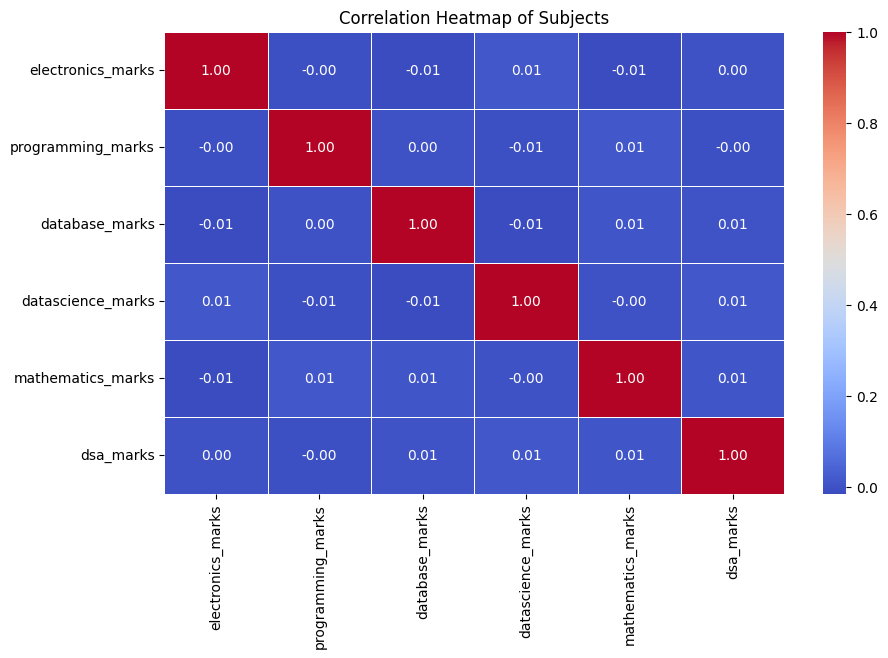

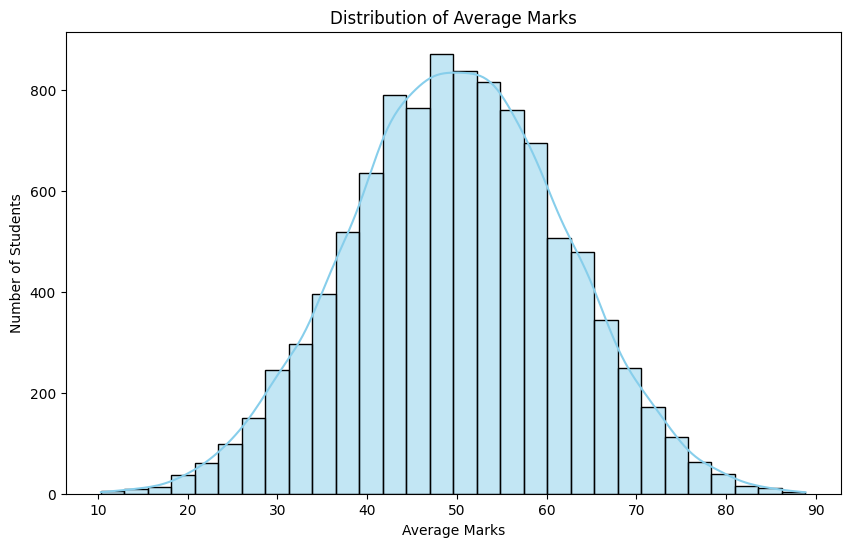

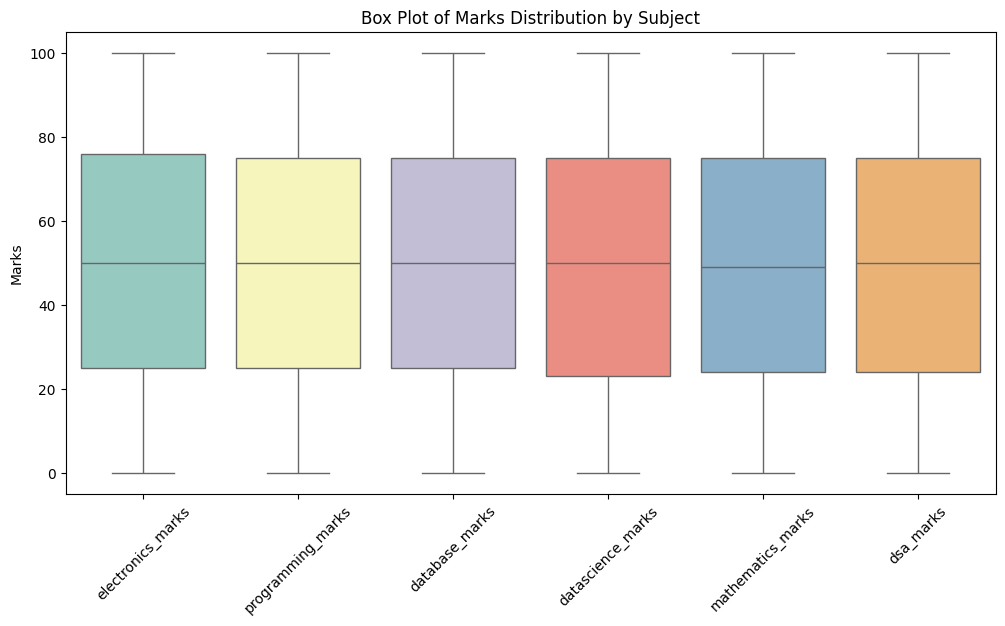

Processed data saved to 'student_performance_enhanced.csv'.


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, avg, count, round as spark_round
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

spark = SparkSession.builder \
    .appName("StudentRecordsProcessing") \
    .getOrCreate()


df = spark.read.csv("student_records.csv", header=True, inferSchema=True)

df_with_avg = df.withColumn(
    "average_marks",
    spark_round(
        (
            col("electronics_marks") +
            col("programming_marks") +
            col("database_marks") +
            col("datascience_marks") +
            col("mathematics_marks") +
            col("dsa_marks")
        ) / 6, 2
    )
)


df_pd = df_with_avg.toPandas()


plt.figure(figsize=(10, 6))
sns.heatmap(df_pd[[
    "electronics_marks", "programming_marks", "database_marks",
    "datascience_marks", "mathematics_marks", "dsa_marks"
]].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Subjects")
plt.show()


plt.figure(figsize=(10, 6))
sns.histplot(df_pd["average_marks"], bins=30, kde=True, color="skyblue")
plt.title("Distribution of Average Marks")
plt.xlabel("Average Marks")
plt.ylabel("Number of Students")
plt.show()


def categorize_marks(marks):
    if marks >= 75:
        return "High Achievers"
    elif marks >= 50:
        return "Average Performers"
    else:
        return "Low Performers"

df_pd["performance_category"] = df_pd["average_marks"].apply(categorize_marks)
category_counts_pd = df_pd["performance_category"].value_counts().reset_index()
category_counts_pd.columns = ["performance_category", "count"]

fig = px.pie(category_counts_pd, values="count", names="performance_category",
             title="Performance Distribution of Students", hole=0.4,
             color_discrete_sequence=px.colors.qualitative.Pastel)
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()


plt.figure(figsize=(12, 6))
sns.boxplot(data=df_pd[[
    "electronics_marks", "programming_marks", "database_marks",
    "datascience_marks", "mathematics_marks", "dsa_marks"
]], palette="Set3")
plt.title("Box Plot of Marks Distribution by Subject")
plt.ylabel("Marks")
plt.xticks(rotation=45)
plt.show()

fig = px.parallel_categories(df_pd, dimensions=[
    "performance_category", "electronics_marks", "programming_marks",
    "database_marks", "datascience_marks", "mathematics_marks", "dsa_marks"
], color="average_marks", color_continuous_scale=px.colors.sequential.Viridis,
    title="Parallel Categories Plot for Student Performance")
fig.show()

df_with_category = spark.createDataFrame(df_pd)
df_with_category.write.csv("student_performance_enhanced.csv", header=True, mode="overwrite")

print("Processed data saved to 'student_performance_enhanced.csv'.")

spark.stop()